<a href="https://colab.research.google.com/github/UiinKim/UiinKim/blob/main/%EC%8A%A4%ED%8C%B8_%EB%A9%94%EC%9D%BC_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [136]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data=pd.read_csv('spam.csv', encoding='latin1')
print('샘플의 수 : ', len(data))

샘플의 수 :  5572


In [137]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [138]:
data=data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [139]:
data['v1']=data['v1'].replace(['ham', 'spam'], [0,1])

In [140]:
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [142]:
data.replace('',np.nan)
data.isnull().any()

v1    False
v2    False
dtype: bool

In [143]:
print(data['v2'].nunique())

5169


In [144]:
data.drop_duplicates(subset=['v2'], inplace=True) #v2열에서 중복된 데이터가 있을 경우 제거
print('샘플의 수 : ', len(data))

샘플의 수 :  5169


<Axes: >

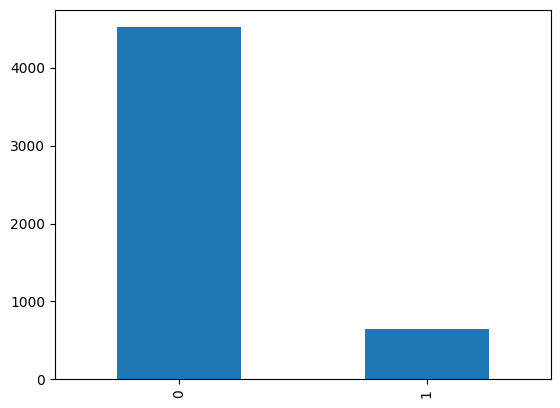

In [145]:
data['v1'].value_counts().plot(kind='bar')

In [146]:
data.groupby('v1').size().reset_index(name='count')#v1으로 그룹화하고 count라는 열을 생성하고 인덱스를 초기화한다. size는 전체 원소의 개수

,v1,count
0,0,4516
1,1,653


In [147]:
print('정상 메일의 비율 : %.3f' %(data['v1'].value_counts()[0]/len(data)*100))
print('스팸 메일의 비율 : %.3f' %(data['v1'].value_counts()[1]/len(data)*100))

정상 메일의 비율 : 87.367
스팸 메일의 비율 : 12.633


In [148]:
X_data=data['v2']
y_data=data['v1']

In [149]:
len(y_data)

5169

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data) #stratify=y_data로 하면 y_data(레이블 값)을 기준으로 비율이 균등하게 test와 train으로 나누어진다.

In [151]:
len(y_train)

4135

In [152]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 87.376%
스팸 메일 = 12.624%


In [153]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded=tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])

[[102, 1, 210, 230, 3, 17, 39], [1, 59, 8, 427, 17, 5, 137, 2, 2326], [157, 180, 12, 13, 98, 93, 47, 9, 40, 3485, 247, 8, 7, 87, 6, 80, 1312, 5, 3486, 7, 2327, 11, 660, 306, 20, 25, 467, 708, 1028, 203, 129, 193, 800, 2328, 23, 1, 144, 71, 2, 111, 78, 43, 2, 130, 11, 800, 186, 122, 1512], [1, 1154, 13, 104, 292], [222, 622, 857, 540, 623, 22, 23, 83, 10, 47, 6, 257, 32, 6, 26, 64, 936, 407]]


In [154]:
word_to_index=tokenizer.word_index

In [155]:
threshold=2
total_cnt=len(word_to_index) #단어의 수
rare_cnt=0 #등장 빈도수가 threshold보다 낮은 단어 개수
total_freq=0 #훈련 데이터에 나오는 모든 단어의 빈도수의 합
rare_freq=0 #등장 빈도수가 threshold보다 낮은 모든 단어의 빈도수의 합

#단어의 빈도수의 쌍을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items(): #단어 이름과 등장횟수로 반복
  total_freq+=value #등장횟수를 더한다.

  #단어의 빈도수가 threshold보다 낮은 경우
  if(value<threshold):
    rare_cnt+=1
    rare_freq+=value

print('등장 빈도가 %s번 이하인 단어의 수 : %d'%(threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt/total_cnt)*100)
print  ('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq/total_freq)*100)


등장 빈도가 1번 이하인 단어의 수 : 4337
단어 집합에서 희귀 단어의 비율 :  55.45326684567191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  6.65745644331875


In [156]:
vocab_size=len(word_to_index)+1
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  7822


메일의 최대 길이 : 189
메일의 평균 길이 : 15.754534


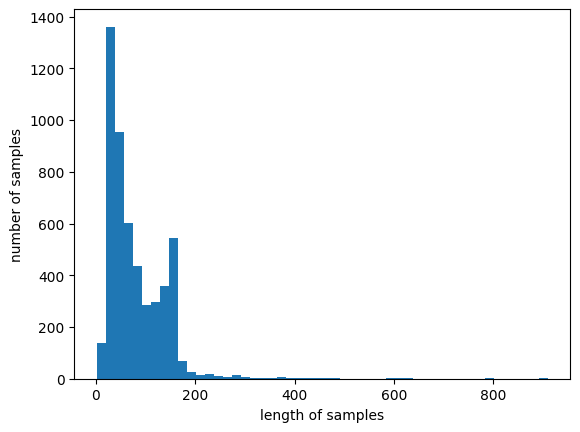

In [157]:
print('메일의 최대 길이 : %d'%(max(len(sample)for sample in X_train_encoded)))
print('메일의 평균 길이 : %f'%(sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [158]:
max_len=189
X_train_padded=pad_sequences(X_train_encoded, maxlen=max_len)
print('훈련된 데이터의 크기', X_train_padded.shape)

훈련된 데이터의 크기 (4135, 189)


In [159]:
#RNN으로 모델 만들기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN

embedding_dim=32
hidden_units=32

model=Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history=model.fit(X_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2) #batch_size의 크기마다 X_train_padded의 데이터의 예측값과 y_train의 값을 비교하여 가중치를 업데이트 한다. validation=0.2로 train 데이터의 20%를 검증 데이터로 분리해서 사용한다.(과적합 방지)

Epoch 1/4
52/52 [==============================] - 3s 36ms/step - loss: 0.2700 - acc: 0.9132 - val_loss: 0.1409 - val_acc: 0.9589
Epoch 2/4
52/52 [==============================] - 2s 31ms/step - loss: 0.0948 - acc: 0.9737 - val_loss: 0.0881 - val_acc: 0.9710
Epoch 3/4
52/52 [==============================] - 2s 31ms/step - loss: 0.0565 - acc: 0.9846 - val_loss: 0.0714 - val_acc: 0.9794
Epoch 4/4
52/52 [==============================] - 2s 31ms/step - loss: 0.0409 - acc: 0.9885 - val_loss: 0.0686 - val_acc: 0.9819


In [160]:
X_test_encoded=tokenizer.texts_to_sequences(X_test)
X_test_padded=pad_sequences(X_test_encoded, maxlen=max_len)
print('\n 테스트 정확도 : %.4f'%(model.evaluate(X_test_padded, y_test)[1]))

33/33 [==============================] - 0s 7ms/step - loss: 0.0656 - acc: 0.9816

 테스트 정확도 : 0.9816


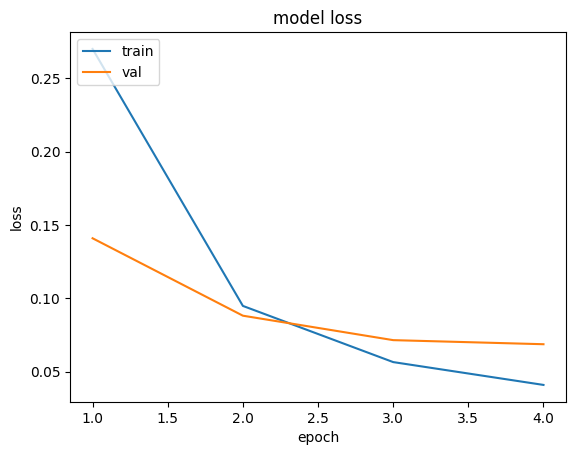

In [161]:
epochs=range(1, len(history.history['acc'])+1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()